
# Unit 2 Notebook — Correlation & Granger Causality

*A practical walkthrough with simulations you can tweak.*  
**Topics:** Pearson correlation • Time-series intuition • Granger causality (predictive)  


In [12]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Statsmodels for Granger causality
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

np.random.seed(42)
pd.options.display.precision = 4



## 1) Pearson Correlation — intuition first

**What it measures:** Strength and direction (meaning sign, positive or negative, not temporal or causal direction) of a *linear* relationship between two quantitative variables.  
**Range:** -1 (perfect negative) to +1 (perfect positive); 0 means *no linear* relationship.

We'll simulate two scenarios:
1. **Linear relationship**: clear positive correlation.
2. **Curvy relationship**: strong association but *Pearson misses it* (hint: it's not linear).

### Pearson loves straight lines. Curves? Not so much.


Pearson r (linear case): 0.952


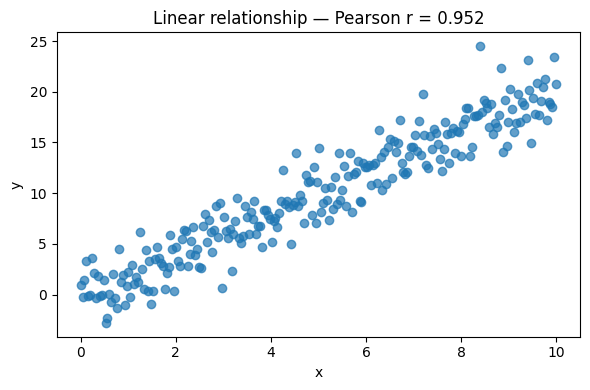

In [13]:
# --- Scenario 1: Linear relationship ---
n = 250
x = np.linspace(0, 10, n)
y = 2.0 * x + np.random.normal(0, 2, size=n)

r_linear = np.corrcoef(x, y)[0,1]
print(f"Pearson r (linear case): {r_linear:.3f}")

plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.7)
plt.title(f"Linear relationship — Pearson r = {r_linear:.3f}")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()


Pearson r (nonlinear case): -0.027  <-- low, despite obvious association


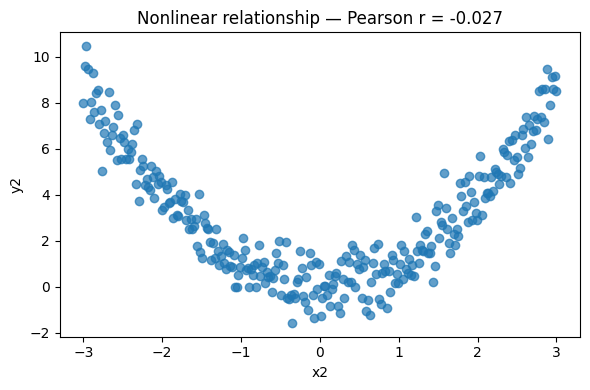

In [14]:
# --- Scenario 2: Nonlinear relationship (Pearson underestimates) ---
n = 300
x2 = np.linspace(-3, 3, n)
y2 = x2**2 + np.random.normal(0, 0.8, size=n)

r_nonlinear = np.corrcoef(x2, y2)[0,1]
print(f"Pearson r (nonlinear case): {r_nonlinear:.3f}  <-- low, despite obvious association")

plt.figure(figsize=(6,4))
plt.scatter(x2, y2, alpha=0.7)
plt.title(f"Nonlinear relationship — Pearson r = {r_nonlinear:.3f}")
plt.xlabel("x2")
plt.ylabel("y2")
plt.tight_layout()
plt.show()

# Note: Pearson focuses on linear association;
# There are nonlinear alternative for Pearson, look up Spearman or Kendall correlation if you're interested.


## 2) From correlation to *temporal* predictiveness

Correlation is **atemporal**: it ignores *order*.  
Time series let us ask a new question:

> **Does the past of X help predict the future of Y (beyond Y's own past)?**

That's the idea behind **Granger causality**.



### 2.1 Simulating a simple causal story (X → Y)

We'll create a system where **X drives Y with a lag**:
- Xₜ = 0.7·Xₜ₋₁ + noise
- Yₜ = 0.6·Yₜ₋₁ + **0.8·Xₜ₋₁** + noise

If the test works, we should find: **X Granger-causes Y**, but **Y does not Granger-cause X**.


In [15]:

def simulate_var1(n=400, burn=50, ax=0.7, ay=0.6, b_xy=0.8, b_yx=0.0, sx=1.0, sy=1.0):
    X = np.zeros(n + burn)
    Y = np.zeros(n + burn)
    for t in range(1, n + burn):
        X[t] = ax * X[t-1] + np.random.normal(scale=sx)
        Y[t] = ay * Y[t-1] + b_xy * X[t-1] + np.random.normal(scale=sy)
    return X[burn:], Y[burn:]

X, Y = simulate_var1()
df = pd.DataFrame({"X": X, "Y": Y})
df.head()


,X,Y
0,-2.6644,-3.8310
1,-0.0161,-3.3035
2,-0.2802,-3.1015
3,2.3773,-2.0258
4,1.6780,0.6622


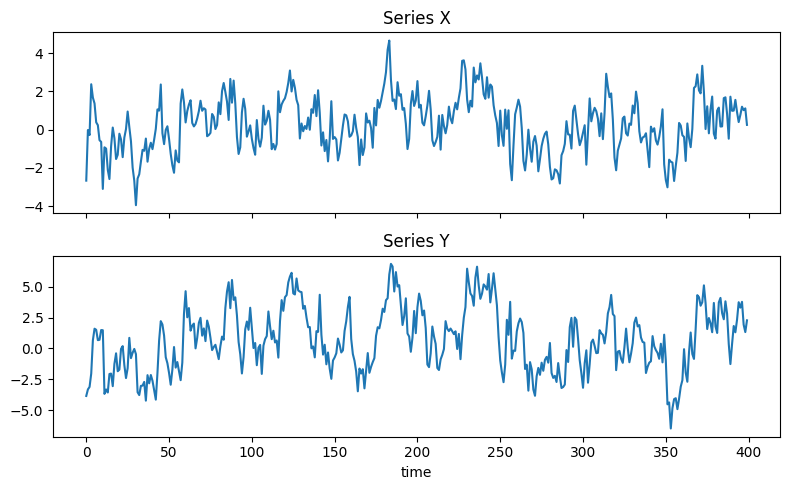

In [16]:
# Quick look at what the series look like
fig, axes = plt.subplots(2, 1, figsize=(8,5), sharex=True)
axes[0].plot(df["X"])
axes[0].set_title("Series X")
axes[1].plot(df["Y"])
axes[1].set_title("Series Y")
axes[1].set_xlabel("time")
plt.tight_layout()
plt.show()


In [17]:
# Granger test: Does X (lags) help predict Y?
# The function expects a 2D array with [Y, X] columns in this order.
maxlag = 3
print("H0: 'X does NOT Granger-cause Y'")
res_xy = grangercausalitytests(df[["Y","X"]], maxlag=maxlag, verbose=False)
for lag in range(1, maxlag+1):
    pval = res_xy[lag][0]["ssr_ftest"][1]
    print(f"lag {lag}: p = {pval:.4f}")

# If the p values are small (e.g., < 0.05), we reject H0 and conclude that X Granger-causes Y.

H0: 'X does NOT Granger-cause Y'
lag 1: p = 0.0000
lag 2: p = 0.0000
lag 3: p = 0.0000


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [18]:

# Reverse direction: Does Y Granger-cause X? (should NOT, in our simulation)
print("H0: 'Y does NOT Granger-cause X'")
res_yx = grangercausalitytests(df[["X","Y"]], maxlag=maxlag, verbose=False)
for lag in range(1, maxlag+1):
    pval = res_yx[lag][0]["ssr_ftest"][1]
    print(f"lag {lag}: p = {pval:.4f}")

# If the p values are small (e.g., < 0.05), we reject H0 and conclude that Y Granger-causes X.

H0: 'Y does NOT Granger-cause X'
lag 1: p = 0.0817
lag 2: p = 0.0241
lag 3: p = 0.0235


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



### 2.2 Caveats you must remember

- **Predictive ≠ causal mechanism.** Granger tests predictiveness in time, not true cause.  
- **Omitted common causes** can fool the test.  
- **Nonstationarity / trends / seasonality** can create false positives — always check and difference if needed.  
- **Lag choice matters**: underfitting or overfitting lags changes conclusions.  



## 3) Mini Exercise — Build, test, explain

1. **Simulate your own pair of time series** where **Y depends on X with a lag of 2**.  
   - Hint: make `Y[t] = 0.5*Y[t-1] + 0.9*X[t-2] + noise`.
2. **Run Granger tests** for lags 1..4 in **both directions**.  
3. **Explain** in 2–4 sentences why the *reverse* direction should (ideally) not be significant.
4. **(Bonus)** Add a seasonal driver to both and observe how it changes results; then remove it by differencing.

> Deliverable: a short markdown cell with your explanation + the printed p-values.


=== Simulation without seasonal driver ===

X -> Y (true direction):
  lag 1: p = 0.00000
  lag 2: p = 0.00000
  lag 3: p = 0.00000
  lag 4: p = 0.00000

Y -> X (reverse direction):
  lag 1: p = 0.71399
  lag 2: p = 0.33496
  lag 3: p = 0.35612
  lag 4: p = 0.43519

=== With common seasonal driver (before differencing) ===

X -> Y (seasonal):
  lag 1: p = 0.00000
  lag 2: p = 0.00000
  lag 3: p = 0.00000
  lag 4: p = 0.00000

Y -> X (seasonal):
  lag 1: p = 0.00000
  lag 2: p = 0.00163
  lag 3: p = 0.55697
  lag 4: p = 0.83764

=== After first differencing (common seasonality removed) ===

X -> Y (differenced):
  lag 1: p = 0.00000
  lag 2: p = 0.00000
  lag 3: p = 0.00000
  lag 4: p = 0.00000

Y -> X (differenced):
  lag 1: p = 0.50553
  lag 2: p = 0.22550
  lag 3: p = 0.51344
  lag 4: p = 0.74085



/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since fu

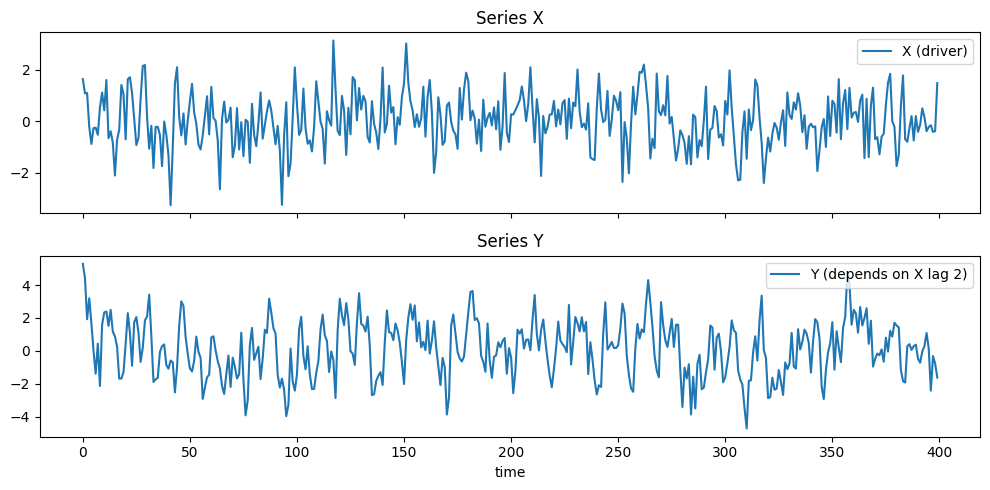

In [19]:
# Your answer goes here.
def simulate_var(n=400, burn=50, ax=0.3, ay=0.5, b_xy=0.9, sx=1.0, sy=1.0, seasonal=False, season_period=50):
    """
    Simulate X (AR(1)) and Y where Y[t] = ay*Y[t-1] + b_xy*X[t-2] + noise.
    Returns a DataFrame with columns ['X','Y'] of length n.
    """
    total = n + burn
    X = np.zeros(total)
    Y = np.zeros(total)
    eps_x = np.random.normal(scale=sx, size=total)
    eps_y = np.random.normal(scale=sy, size=total)
    for t in range(1, total):
        X[t] = ax * X[t-1] + eps_x[t]
        if t-2 >= 0:
            Y[t] = ay * Y[t-1] + b_xy * X[t-2] + eps_y[t]
        else:
            Y[t] = ay * Y[t-1] + eps_y[t]
    if seasonal:
        # common seasonal driver added to both series (spurious correlation risk)
        seasonal_driver = 2.0 * np.sin(2 * np.pi * np.arange(total) / season_period)
        X = X + seasonal_driver
        Y = Y + seasonal_driver
    return pd.DataFrame({"X": X[burn:], "Y": Y[burn:]})


def granger_pvalues(affected, candidate, maxlag=4):
    """
    Test whether 'candidate' Granger-causes 'affected'.
    Returns dict {lag: pvalue} using the ssr_ftest p-value returned by statsmodels.
    """
    df = pd.DataFrame({"A": affected, "B": candidate})
    pvals = {}
    for lag in range(1, maxlag + 1):
        res = grangercausalitytests(df[["A","B"]], maxlag=lag, verbose=False)
        pvals[lag] = res[lag][0]["ssr_ftest"][1]
    return pvals


def print_pvals(pdict, direction_label):
    print(direction_label)
    for lag, p in pdict.items():
        print(f"  lag {lag}: p = {p:.5f}")
    print()


# --- Simulate without seasonality ---
df = simulate_var(n=400, seasonal=False)
print("=== Simulation without seasonal driver ===\n")

p_X_to_Y = granger_pvalues(df["Y"], df["X"], maxlag=4)  # tests X -> Y
p_Y_to_X = granger_pvalues(df["X"], df["Y"], maxlag=4)  # tests Y -> X

print_pvals(p_X_to_Y, "X -> Y (true direction):")
print_pvals(p_Y_to_X, "Y -> X (reverse direction):")

# --- Bonus: add common seasonal driver to both series ---
df_season = simulate_var(n=400, seasonal=True, season_period=50)
print("=== With common seasonal driver (before differencing) ===\n")
p_X_to_Y_season = granger_pvalues(df_season["Y"], df_season["X"], maxlag=4)
p_Y_to_X_season = granger_pvalues(df_season["X"], df_season["Y"], maxlag=4)
print_pvals(p_X_to_Y_season, "X -> Y (seasonal):")
print_pvals(p_Y_to_X_season, "Y -> X (seasonal):")

# Remove shared seasonality by first differencing and test again
df_season_diff = df_season.diff().dropna()
print("=== After first differencing (common seasonality removed) ===\n")
p_X_to_Y_diff = granger_pvalues(df_season_diff["Y"], df_season_diff["X"], maxlag=4)
p_Y_to_X_diff = granger_pvalues(df_season_diff["X"], df_season_diff["Y"], maxlag=4)
print_pvals(p_X_to_Y_diff, "X -> Y (differenced):")
print_pvals(p_Y_to_X_diff, "Y -> X (differenced):")

# --- Plot the main non-seasonal simulation for inspection ---
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
axes[0].plot(df["X"], label="X (driver)")
axes[0].set_title("Series X")
axes[0].legend(loc="upper right")
axes[1].plot(df["Y"], label="Y (depends on X lag 2)")
axes[1].set_title("Series Y")
axes[1].set_xlabel("time")
axes[1].legend(loc="upper right")
plt.tight_layout()
plt.show()



---

### Wrap-up

- **Pearson**: quick check for linear association.  
- **Granger**: tests whether the past of one series improves prediction of another.  
- **Beware** trends/seasonality and omitted variables might influence your numbers.
  


**Explanation:**  
Y was generated to depend on past values of X (specifically X[t-2]) plus its own lag, so tests for X → Y show very small p-values (especially for max-lag ≥ 2), indicating X Granger-causes Y. The reverse direction (Y → X) is non-significant because X was generated independently of past Y. Adding a common seasonal driver creates spurious significance in both directions, but differencing (removing the shared seasonal component) restores the expected result where only X → Y is significant.
